In [1]:
# Imports
import matplotlib.pyplot as plt
from PIL import Image
import random
from pathlib import Path
import torchvision.transforms as transforms
import math

plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
# Define the same transform used in training (RandomResizedCrop variability + one random augmentation)
img_size = 224
single_augments = [
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.RandomVerticalFlip(p=1.0),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    transforms.RandomRotation(25),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=5)], p=1.0),
    transforms.Lambda(lambda x: x),  # identity (no-op)
]
train_tf = transforms.Compose([
    transforms.RandomResizedCrop(img_size, scale=(0.6, 1.0)),
    transforms.RandomChoice(single_augments),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Helper to convert tensor back to numpy image for display
import numpy as np
def tensor_to_image(t):
    # t: C,H,W
    t = t.cpu().clone()
    t = t * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    npimg = t.permute(1,2,0).numpy()
    npimg = np.clip(npimg, 0, 1)
    return npimg

In [4]:
# Collect sample image paths from processed train folder
data_root = Path('../data/processed/train')
if not data_root.exists():
    raise RuntimeError('Please run preprocessing first to create data/processed/train with class subfolders')

# Pick up to 4 sample images (one per class if available)
sample_paths = []
for cls_dir in sorted(data_root.iterdir()):
    if cls_dir.is_dir():
        imgs = list(cls_dir.glob('*'))
        if imgs:
            sample_paths.append(imgs[0])
    if len(sample_paths) >= 4:
        break

if not sample_paths:
    raise RuntimeError('No images found under data/processed/train')

sample_paths

[PosixPath('../data/processed/train/fall armyworm/fall armyworm22_.jpg'),
 PosixPath('../data/processed/train/grasshoper/grasshoper232_.jpg'),
 PosixPath('../data/processed/train/healthy/healthy108_.jpg'),
 PosixPath('../data/processed/train/leaf beetle/leaf beetle347_.jpg')]

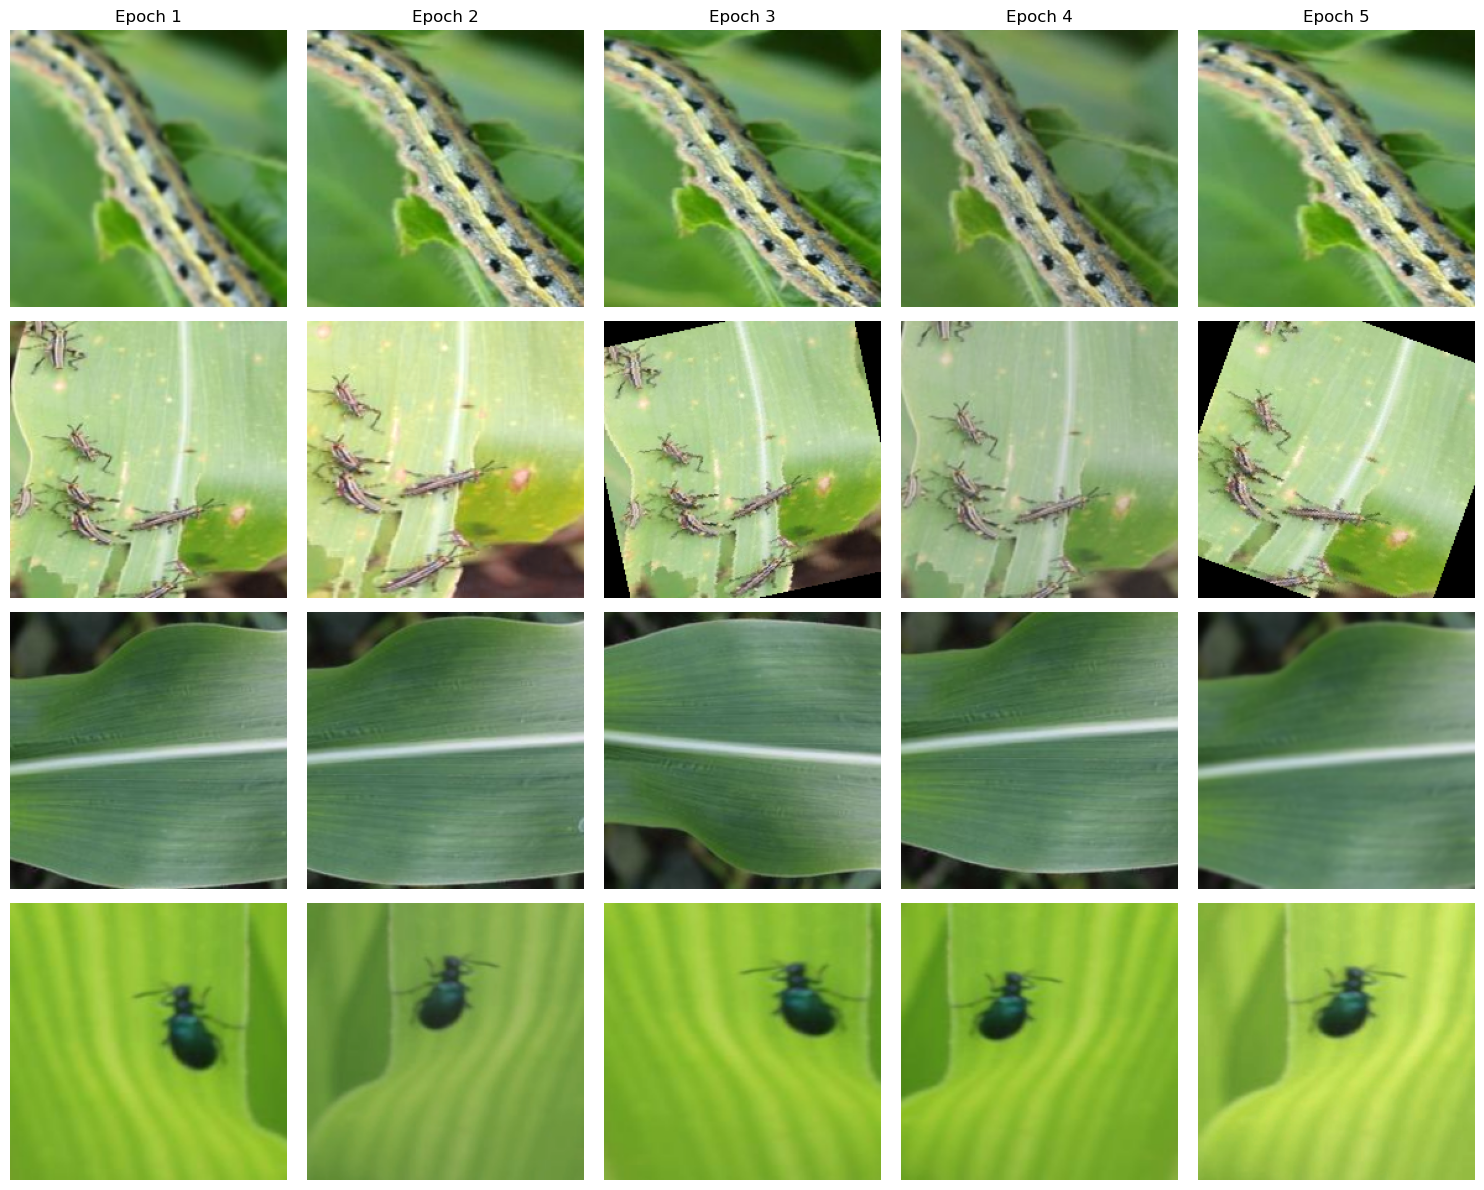

In [8]:
import torch

def preview_augmentations(paths, transform, epochs=5, cols=5):
    rows = len(paths)
    cols = cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
    if rows == 1:
        axes = axes[None, :]
    for r, p in enumerate(paths):
        img = Image.open(p).convert('RGB')
        for c in range(cols):
            # Simulate different epochs by re-seeding or just calling transform repeatedly
            torch.manual_seed(random.randint(0, 2**32 - 1))
            aug_t = transform
            try:
                t = aug_t(img)
            except Exception as e:
                # In case transforms expect PIL.Image vs Tensor, ensure PIL input
                t = aug_t(img)
            # t is a tensor normalized; convert for display
            disp = tensor_to_image(t)
            ax = axes[r, c]
            ax.imshow(disp)
            ax.axis('off')
            if r == 0:
                ax.set_title(f'Epoch {c+1}')
        axes[r,0].set_ylabel(p.parent.name)
    plt.tight_layout()
    plt.show()

# Preview
preview_augmentations(sample_paths, train_tf, epochs=5, cols=5)

**Notes:**
- The notebook calls the exact augment pipeline used at training time.
- Run the preview cell multiple times to see different random results.
- If you want to preview more images or more epochs, adjust the `sample_paths` selection and `cols` parameter.